In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
df.head()
df.shape
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [7]:
#convertng date column to datetime

df["date"]= pd.to_datetime(df["date"])

df = df.sort_values("date")
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
890,890,2013-01-01,33,SEAFOOD,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000882,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000874,3000874,2017-08-15,9,LADIESWEAR,10.000,0


In [14]:
df = df.rename(columns={
    'store_nbr': 'Store',
    'family': 'Dept',
    'date': 'Date',
    'sales': 'Weekly_Sales'
})


df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

store_id = 1
dept_id = df['Dept'].iloc[0]  # safer than hardcoding

df_sd = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)].copy()
df_sd.head()



,id,Date,Store,Dept,Weekly_Sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0


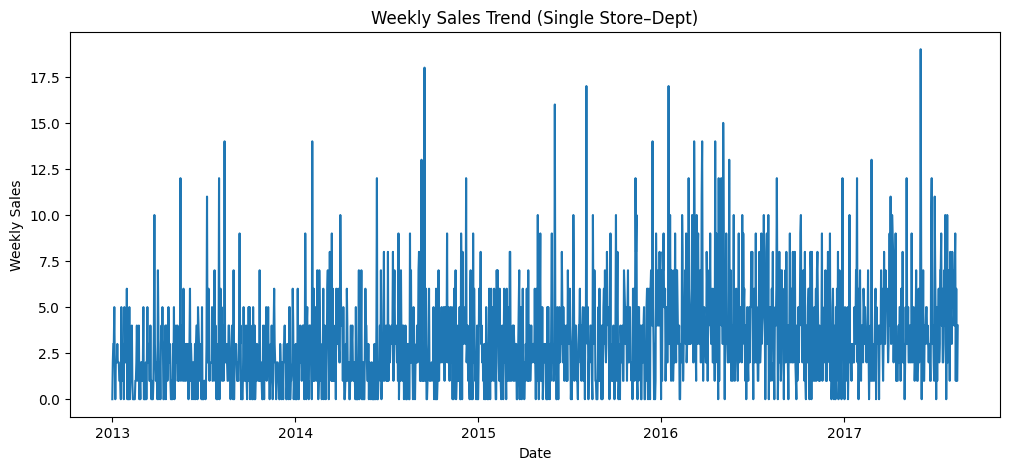

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df_sd['Date'], df_sd['Weekly_Sales'])
plt.title('Weekly Sales Trend (Single Store–Dept)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


In [16]:
# 4-week rolling average demand
df_sd['rolling_avg_demand'] = df_sd['Weekly_Sales'].rolling(window=4).mean()


In [17]:
# Difference from rolling average
df_sd['demand_gap'] = df_sd['rolling_avg_demand'] - df_sd['Weekly_Sales']

# Flag potential constrained demand
df_sd['capped_demand'] = (
    (df_sd['demand_gap'] > 0) &
    (df_sd['Weekly_Sales'] < df_sd['rolling_avg_demand'])
).astype(int)


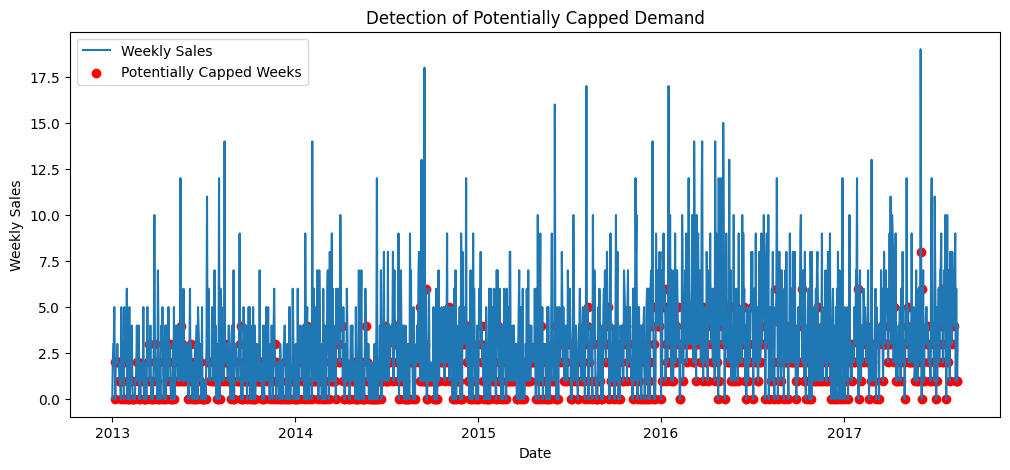

In [18]:
plt.figure(figsize=(12,5))

plt.plot(df_sd['Date'], df_sd['Weekly_Sales'], label='Weekly Sales')
plt.scatter(
    df_sd[df_sd['capped_demand'] == 1]['Date'],
    df_sd[df_sd['capped_demand'] == 1]['Weekly_Sales'],
    color='red',
    label='Potentially Capped Weeks'
)

plt.legend()
plt.title('Detection of Potentially Capped Demand')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


In [19]:
df_sd['capped_demand'].value_counts()


,count
capped_demand,
1,893
0,791


In [20]:
# Start with sales as baseline demand
df_sd['estimated_demand'] = df_sd['Weekly_Sales']


In [21]:
df_sd.loc[df_sd['capped_demand'] == 1, 'estimated_demand'] = (
    df_sd.loc[df_sd['capped_demand'] == 1, 'rolling_avg_demand']
)


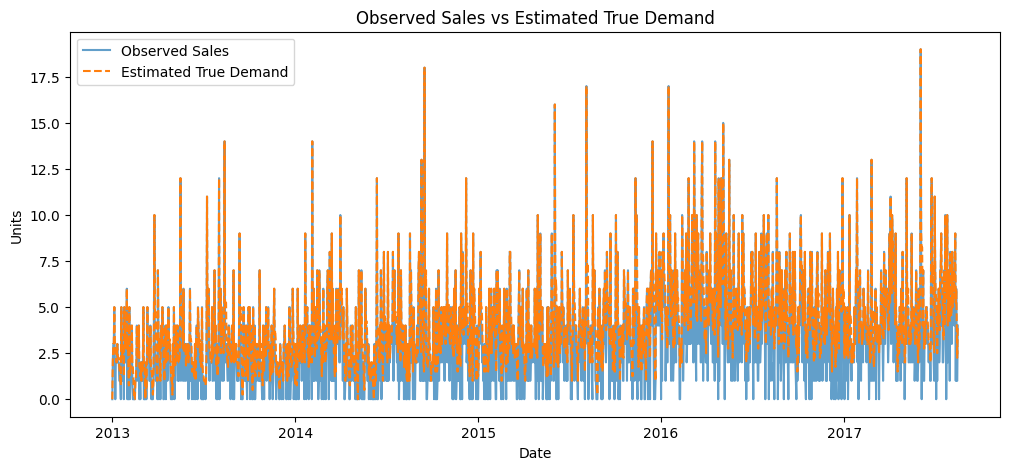

In [22]:
plt.figure(figsize=(12,5))

plt.plot(df_sd['Date'], df_sd['Weekly_Sales'], label='Observed Sales', alpha=0.7)
plt.plot(df_sd['Date'], df_sd['estimated_demand'], label='Estimated True Demand', linestyle='--')

plt.title('Observed Sales vs Estimated True Demand')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.show()


In [23]:
df_sd['hidden_demand'] = df_sd['estimated_demand'] - df_sd['Weekly_Sales']


In [24]:
df_sd['hidden_demand'].sum()


np.float64(1464.5)

In [25]:
# Hidden demand should never be negative
(df_sd['hidden_demand'] < 0).sum()


np.int64(0)

In [26]:
# Define train-test split (80% train, 20% test)
split_index = int(len(df_sd) * 0.8)

train = df_sd.iloc[:split_index]
test = df_sd.iloc[split_index:]


In [27]:
def rolling_forecast(series, window=4):
    """
    Forecasts next value using rolling mean of previous observations
    """
    predictions = []
    history = list(series)

    for _ in range(len(test)):
        forecast = np.mean(history[-window:])
        predictions.append(forecast)
        history.append(forecast)

    return predictions


In [28]:
naive_predictions = rolling_forecast(train['Weekly_Sales'])


In [29]:
corrected_predictions = rolling_forecast(train['estimated_demand'])


In [30]:
forecast_df = test[['Date', 'Weekly_Sales']].copy()

forecast_df['naive_forecast'] = naive_predictions
forecast_df['corrected_forecast'] = corrected_predictions


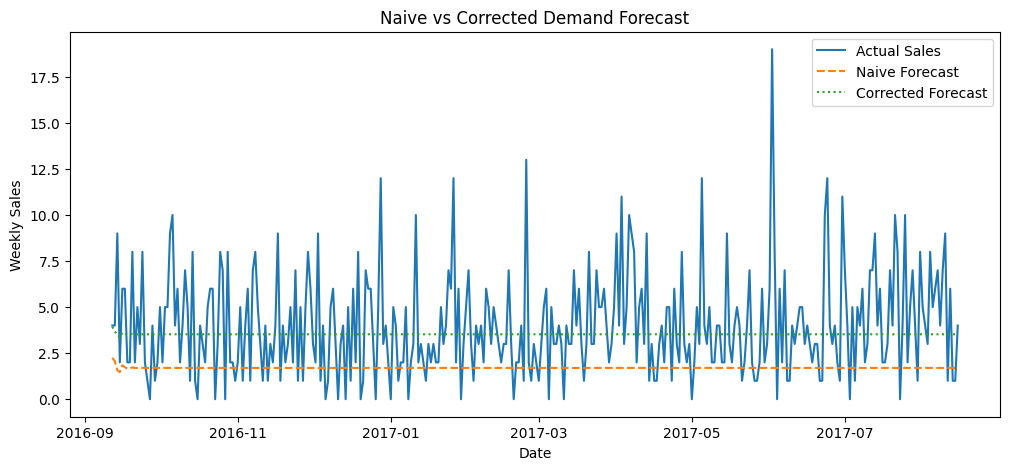

In [31]:
plt.figure(figsize=(12,5))

plt.plot(forecast_df['Date'], forecast_df['Weekly_Sales'], label='Actual Sales')
plt.plot(forecast_df['Date'], forecast_df['naive_forecast'], label='Naive Forecast', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['corrected_forecast'], label='Corrected Forecast', linestyle=':')

plt.title('Naive vs Corrected Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error

naive_mae = mean_absolute_error(
    forecast_df['Weekly_Sales'],
    forecast_df['naive_forecast']
)

corrected_mae = mean_absolute_error(
    forecast_df['Weekly_Sales'],
    forecast_df['corrected_forecast']
)

naive_mae, corrected_mae


(2.6646801100856496, 2.1472238575578073)